In [2]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
# from transformers import *
from transformers import BertTokenizer

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
# 시각화

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [4]:
# random seed 고정
tf.random.set_seed(1234)
np.random.seed(1234)

BATCH_SIZE = 32
NUM_EPOCHS = 3
VALID_SPLIT = 0.2
MAX_LEN = 39 # EDA에서 추출된 Max Length
DATA_IN_PATH = 'data_in/KOR'
DATA_OUT_PATH = "data_out/KOR"

In [5]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", cache_dir='bert_ckpt', do_lower_case=False)

/opt/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## 토크나이저 테스트

In [6]:
test_sentence = "안녕하세요, 반갑습니다."

encode = tokenizer.encode(test_sentence)
token_print = [tokenizer.decode(token) for token in encode]

print(encode)
print(token_print)


[101, 9521, 118741, 35506, 24982, 48549, 117, 9321, 118610, 119081, 48345, 119, 102]
['[ C L S ]', '안', '# # 녕', '# # 하', '# # 세', '# # 요', ',', '반', '# # 갑', '# # 습', '# # 니 다', '.', '[ S E P ]']


In [7]:
kor_encode = tokenizer.encode("안녕하세요, 반갑습니다.")
eng_encode = tokenizer.encode("Hello world")
kor_decode = tokenizer.decode(kor_encode)
eng_decode = tokenizer.decode(eng_encode)
print(kor_encode)
print(eng_encode)
print(kor_decode)
print(eng_decode)

[101, 9521, 118741, 35506, 24982, 48549, 117, 9321, 118610, 119081, 48345, 119, 102]
[101, 31178, 11356, 102]
[CLS] 안녕하세요, 반갑습니다. [SEP]
[CLS] Hello world [SEP]


## Korean Moview Review Classification

In [8]:
# 데이터 전처리 준비
DATA_TRAIN_PATH = os.path.join(DATA_IN_PATH, "naver_movie", "ratings_train.txt")
DATA_TEST_PATH = os.path.join(DATA_IN_PATH, "naver_movie", "ratings_test.txt")

train_data = pd.read_csv(DATA_TRAIN_PATH, header =0, delimiter = '\t', quoting = 3)
train_data = train_data.dropna()
train_data.head(10)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


In [9]:
# 스페셜 토큰
print(tokenizer.all_special_tokens, '\n', tokenizer.all_special_tokens)

# 토크나이저 테스트 하기 
kor_encode = tokenizer.encode("안녕하세요, 반갑습니다.")
eng_encode = tokenizer.encode("Hello world")

kor_decode = tokenizer.decode(kor_encode)
eng_decode = tokenizer.decode(eng_encode)

print(kor_encode)
print(eng_encode)
print(kor_decode)
print(eng_decode)

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]'] 
 ['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']
[101, 9521, 118741, 35506, 24982, 48549, 117, 9321, 118610, 119081, 48345, 119, 102]
[101, 31178, 11356, 102]
[CLS] 안녕하세요, 반갑습니다. [SEP]
[CLS] Hello world [SEP]


In [10]:
# Bert Tokenizer

# 참조: https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus

# 토크나이저와 padding 도 동시에 진행될 수 있도록 사용
def bert_tokenizer(sent, MAX_LEN):
    
    encoded_dict = tokenizer.encode_plus(
        text = sent,
        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN,           # Pad & truncate all sentences.
        pad_to_max_length = True,
        return_attention_mask = True   # Construct attn. masks.
        
    )
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] # And its attention mask (simply differentiates padding from non-padding).
    token_type_id = encoded_dict['token_type_ids'] # differentiate two sentences
    
    return input_id, attention_mask, token_type_id

In [11]:
input_ids = []
attention_masks = []
token_type_ids = []
train_data_labels = []

for train_sent, train_label in tqdm(zip(train_data['document'], train_data['label']), total=len(train_data)):
    try:
        # 토크나이저와 padding 도 동시에 진행될 수 있도록 사용
        input_id, attention_mask, token_type_id = bert_tokenizer(train_sent, MAX_LEN)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        train_data_labels.append(train_label)

    except Exception as e:
        print(e)
        print(train_sent)
        pass

train_movie_input_ids = np.array(input_ids, dtype=int)
train_movie_attention_masks = np.array(attention_masks, dtype=int)
train_movie_type_ids = np.array(token_type_ids, dtype=int)
train_movie_inputs = (train_movie_input_ids, train_movie_attention_masks, train_movie_type_ids)

train_data_labels = np.asarray(train_data_labels, dtype=np.int32)

print(f"# sents: {len(train_movie_input_ids)}, # labels: {len(train_data_labels)}")

  0%|                                                | 0/149995 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████

# sents: 149995, # labels: 149995


In [12]:
# 최대 길이 = 39
input_id = train_movie_input_ids[1]
attention_mask = train_movie_attention_masks[1]
token_type_id = train_movie_type_ids[1]

print(input_id)
print(attention_mask)
print(token_type_id)
print(tokenizer.decode(input_id))

[   101    100    119    119    119   9928  58823  30005  11664   9757
 118823  30858  18227 119219    119    119    119    119   9580  41605
  25486  12310  20626  23466   8843 118986  12508   9523  17196  16439
    102      0      0      0      0      0      0      0      0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
[CLS] [UNK]... 포스터보고 초딩영화줄.... 오버연기조차 가볍지 않구나 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


## 모델 생성 (fine_tuning)

In [13]:
from transformers import TFBertModel

In [14]:
class TFBertClassifier(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertClassifier, self).__init__()

        self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range), 
                                                name="classifier")
        
    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
        
        #outputs 값: # sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1] 
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.classifier(pooled_output)

        return logits

cls_model = TFBertClassifier(model_name='bert-base-multilingual-cased',
                                  dir_path='bert_ckpt',
                                  num_class=2)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [15]:
# 학습 준비하기 
optimizer = tf.keras.optimizers.Adam(3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer, loss= loss, metrics=[metric])

In [16]:
model_name = "tf2_bert_naver_movie"

# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, '.weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

# 학습과 eval 시작
history = cls_model.fit(train_movie_inputs, train_data_labels, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, 
                        validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

print(history.history)

data_out/KOR/tf2_bert_naver_movie -- Folder already exists 

Epoch 1/3
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5351 - loss: 0.6886
Epoch 1: val_accuracy improved from -inf to 0.62549, saving model to data_out/KOR/tf2_bert_naver_movie/.weights.h5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 5048s 1s/step - accuracy: 0.5351 - loss: 0.6886 - val_accuracy: 0.6255 - val_loss: 0.6639
Epoch 2/3
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6075 - loss: 0.6626
Epoch 2: val_accuracy improved from 0.62549 to 0.64895, saving model to data_out/KOR/tf2_bert_naver_movie/.weights.h5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 9616s 3s/step - accuracy: 0.6075 - loss: 0.6626 - val_accuracy: 0.6490 - val_loss: 0.6478
Epoch 3/3
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 0s 923ms/step - accuracy: 0.6340 - loss: 0.6485
Epoch 3: val_accuracy improved from 0.64895 to 0.65809, saving model to data_out/KOR/tf2_bert_naver_movie/.weights.h5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 4293s 1s/step - accuracy: 0.6340 - loss: 0.6485 - val_

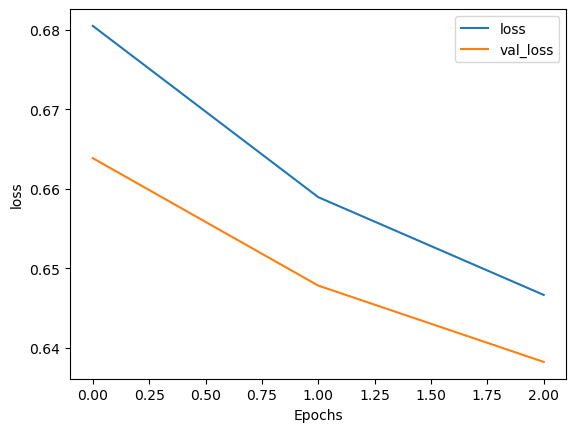

In [17]:
plot_graphs(history, 'loss')

# Korean Movie Review Test 데이터

In [18]:
test_data = pd.read_csv(DATA_TEST_PATH, header = 0, delimiter = '\t', quoting = 3)
test_data = test_data.dropna()
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [19]:
input_ids = []
attention_masks = []
token_type_ids = []
test_data_labels = []

for test_sent, test_label in tqdm(zip(test_data["document"], test_data["label"])):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(test_sent, MAX_LEN)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        test_data_labels.append(test_label)
    except Exception as e:
        print(e)
        print(test_sent)
        pass

test_movie_input_ids = np.array(input_ids, dtype=int)
test_movie_attention_masks = np.array(attention_masks, dtype=int)
test_movie_type_ids = np.array(token_type_ids, dtype=int)
test_movie_inputs = (test_movie_input_ids, test_movie_attention_masks, test_movie_type_ids)

test_data_labels = np.asarray(test_data_labels, dtype=np.int32) #레이블 토크나이징 리스트

print("num sents, labels {}, {}".format(len(test_movie_input_ids), len(test_data_labels)))

0it [00:00, ?it/s]/opt/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
49997it [00:04, 10338.87it/s]

num sents, labels 49997, 49997


In [20]:
result = cls_model.evaluate(test_movie_inputs, test_data_labels, batch_size = 1024)
print(f"test loss, test acc: {result}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 1337s 27s/step - accuracy: 0.6495 - loss: 0.6404
test loss, test acc: [0.6401991248130798, 0.6499390006065369]
